# Introduction to Sparsity I

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018 (updated in 2023)    
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
 * [Objective](#Objective)
 * [Sparsity Definition](#Sparsity-Definition)
1. [Time-Frequency Example](#Time-Frequency-Example)
 * [Signal](#Signal)
 * [Discrete Fourier Transform](#Discrete-Fourier-Transform)
 * [Fast Fourier Transform](#Fast-Fourier-Transform)
1. [Sparsity](#Sparsity)
 * [Sparse Representation](#Sparse-Representation)
 * [Measures of Sparsity](#Measures-of-Sparsity)
 * [Promoting Sparsity](#Promoting-Sparsity)
 * [Median Absolute Deviation](#Median-Absolute-Deviation)
 * [Sparse Regularisation](#Sparse-Regularisation)
1. [Denoising Example](#Denoising-Example)
 * [Choose Sparse Representation](#Choose-Sparse-Representation)
 * [Denoising](#Denoising)
 * [Residual](#Residual)
1. [Hints](#Hints)

## Set-Up

Here we will import a couple of packages that will be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Import the numpy package with the alias np.
import numpy as np

# Import interactive widgets.
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Select

# Import tutorial plotting functions.
from sparsity_tutorial import plot


## Introduction

### <font color='#007acc'>Objective</font>

The objective of this notebook is to introduce the concept of sparsity, particularly in the context of solving inverse problems. To that end, the following examples focus on providing some basic practical applications of the tools and techniques used in sparse analysis. This tutorial does not provide all of mathematical background and readers are encouraged to refer to the following resources for more in-depth explanations.

* <a href="http://www.cambridge.org/us/academic/subjects/computer-science/computer-graphics-image-processing-and-robotics/sparse-image-and-signal-processing-wavelets-and-related-geometric-multiscale-analysis-2nd-edition?format=HB&isbn=9781107088061#3G4HZKumhWjJLe2A.97" target_="blank">Sparse Image and Signal Processing (2015)</a>

### <font color='#007acc'>Sparsity Definition</font>

A sparse signal is one that is comprised mostly of zeros when expressed in the appropriate basis, in other words the only a few coefficients are required to represent the entire signal. This is an inherent propery of the signal that can be expolited to great effect.

A signal $x\in\mathbb{R}^N$, *i.e.* a discrete signal with $N$ coefficients $x_i$, is exactly $k$-sparse if only $k$ of its coefficients are non-zero. In practice, however, one generally deals with approximately sparse signals in which the majority of the coefficients are very small with respect to those that carry the majority of the information. Additionally, some signals that are not naturally sparse can be "sparsified" with an appropriate transform basis.

> Note that by default the term signal will be used to refer to discrete signals.


## Time-Frequency Example

### <font color='#007acc'>Signal</font>

Let's start with a simple sine wave example. We have a time series signal where

$$y = \sin(t)$$

with a sampling rate of 30 and a frequency of 2Hz. We can display this function as follows

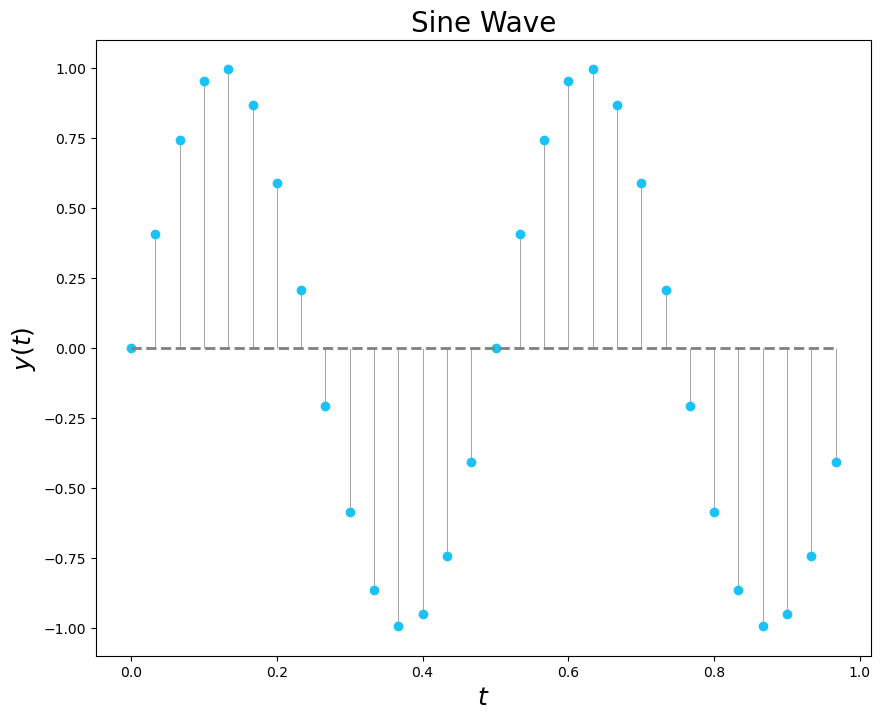

In [2]:
# Set the signal properties.
sampling_rate = 30.0
frequency = 2

# Set a range of t values from 0 to 1 spaced according to the sampling rate.
t = np.arange(0, 1, 1.0 / sampling_rate)

# Get the corresponding y values.
y = np.sin(2 * np.pi * frequency * t)

# Plot the signal
plot.stem_plot(y, x_vals=t, title='Sine Wave', imag=False, ylim=(-1.1, 1.1), xlab='$t$', ylab='$y(t)$')

We can see that out of the 30 coefficients only 2 are equal to zero and therefore this signal is clearly not sparse according the definition provided.

### <font color='#007acc'>Discrete Fourier Transform</font>

We can transform our signal using the <a href="https://en.wikipedia.org/wiki/Discrete_Fourier_transform" target_="blank">Discrete Fourier Transform (DFT)</a> in order to examine its frequency components. 

The DFT of a signal $x$ is given by

$$X_k = \sum_{n=0}^{N-1}x_n e^{-i2\pi kn/N}$$

which can be implemented as follows.

In [3]:
# Calculate the DFT of a given signal
def dft(data):

    xn = np.asarray(data, dtype=float)
    N = data.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    return np.exp(-2j * np.pi * k * n / N) @ xn

Using this function we can compute the normalised DFT of the time series signal.

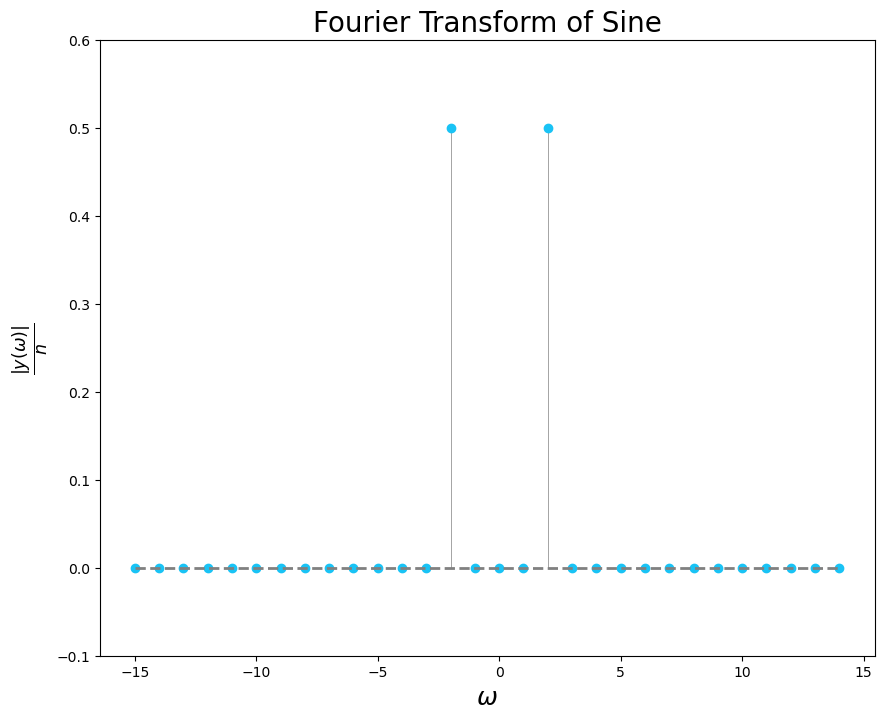

In [4]:
# Get the frequency range.
w = np.fft.fftfreq(t.size, 1 / sampling_rate)

# Calculate the normalised DFT of the signal.
y_fft = np.abs(dft(y)) / y.size 

# Plot the signal
plot.stem_plot(
    y_fft, 
    x_vals=w, 
    title='Fourier Transform of Sine', 
    imag=False, 
    ylim=(-0.1, 0.6),
    xlab='$\omega$', 
    ylab=r'$\frac{|y(\omega)|}{n}$',
)

Now, we have only two coefficients which are non-zero (in fact we only need one as the signal is symmetric in Fourier space). So, although in its natural domain our signal does not appear to be sparse, we were able to find a sparse representation in a different basis.

So, how can the knowledge that a given signal is sparse in a given domain be useful?

### <font color='#007acc'>Fast Fourier Transform</font>

Note that we can more easily convert signals back and forth between the direct and Fourier space using the <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" target_="blank">Fast Fourier Transform (FFT)</a>.

In [5]:
# FFT
def fft(data):
    
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(data)))

# Inverse FFT
def ifft(data):

    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(data)))


## Sparsity

We can use the knowledge that a signal is sparse as prior knowledge when solving an inverse problem. In other words, if we know in advance that the signal we are trying to recover is sparse in a given domain we can impose this property upon our reconstruction. This enables us to reduce the parameter space and allows us to converge upon a better and simpler solution.



### <font color='#007acc'>Sparse Representation</font>

A signal $x$ can be respresented as

$$x = \phi\alpha = \sum_{i=1}^n\phi_i\alpha_i$$

where $\alpha$ are the sparse coefficients of $x$ in the dictionary $\phi$ and $n$ is the sparsity of the signal. Each $\phi_i$ corresponds to an *atom* of the dictionay $\phi$. In the case of Fourier decomposition the atoms are sinusoids and when $\phi$ is a matrix the atoms are the columns of the matrix.

### <font color='#007acc'>Measures of Sparsity</font>

The true sparsity of a signal can be measured with the $l_0$ pseudo-norm.

$$\|x\|_0 = \text{Card}(\text{Supp}(x))$$

*i.e.* the number of non-zero elements in the signal. However, this function is non-convex and is computationally hard  to solve. Therefore, in practice the convex $l_1$ norm is used instead.

$$\|x\|_1 = \sum_{i=1}^n |x_i|$$

The $l_1$ norm is the closest convex norm to $l_0$ and <a href="https://ieeexplore.ieee.org/document/959265/" target_="blank">Donoho and Huo (1999)</a> have shown that for sufficiently sparse signals the two norms are equivalent.

We can use this to measure the sparsity of our time-frequency example.

In [6]:
# Function to measure the l1 norm.
def l1_norm(signal):
    
    return np.sum(np.abs(signal))

# Get the l1 norm of the time and frequency signals.
print('The l1 norm of the time signal:', l1_norm(y))
print('The l1 norm of the frequency signal:', l1_norm(y_fft))

The l1 norm of the time signal: 19.028728908445174
The l1 norm of the frequency signal: 1.000000000000012


As expected the frequency signal is significantly more sparse.

### <font color='#007acc'>Promoting Sparsity</font>

In order to actually produce solutions that are more sparse one typically performs a thresholding operation in the sparse domain.

Here we introduce the soft thresholding operator and compare it with a more commonly known hard thresholding operator.

**Hard Thresholding**

$$HT_{\lambda}(x_i) = \begin{cases} x_i & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

**Soft Thresholding**

$$ST_{\lambda}(x_i) = \begin{cases} x_i - \lambda\text{sign}(x_i) & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

These operations can be implemented with the following functions.

In [7]:
# Function for performing hard thresholding.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Function for performing soft thresholding.
def soft_thresh(signal, threshold):
    
    return np.sign(signal) * (np.abs(signal) - threshold) * (np.abs(signal) >= threshold)

In the following cell you can see how these functions work on the following matrix for different values of the threshold, $\lambda$.

$$M = \begin{bmatrix} 
1 & 2 & 3 & 4 & 5 \\
6 & 7 & 8 & 9 & 10 \\
11 & 12 & 13 & 14 & 15 \\
6 & 17 & 18 & 19 & 20 \\
21 & 22 & 23 & 24 & 25 
\end{bmatrix}$$

#### <font color='#fdbf00'>INTERACTIVE CELL</font>

In [8]:
######################################
# YOU SHOULD INTERACT WITH THIS CELL #
######################################

def test_thresh(thresh_type=None, lambda_val=None):

    matrix = np.arange(25).reshape(5, 5) + 1
    
    if thresh_type == 'Hard':
        thresh_matrix = hard_thresh(matrix, lambda_val)
    elif thresh_type == 'Soft':
        thresh_matrix = soft_thresh(matrix, lambda_val)
        
    plot.display(thresh_matrix, vmin=0, vmax=25)
    
    print(thresh_matrix)
    print()
    print('The l1 norm of the matrix:', l1_norm(thresh_matrix))
    
lambda_slider = IntSlider(value=0, min=0, max=26, step=1)
thresh_option = Select(options=['Hard', 'Soft'], value='Hard', description='Threshold Type', disabled=False)
    
interact(test_thresh, thresh_type=thresh_option, lambda_val=lambda_slider)

interactive(children=(Select(description='Threshold Type', options=('Hard', 'Soft'), value='Hard'), IntSlider(…

<function __main__.test_thresh(thresh_type=None, lambda_val=None)>

### <font color='#007acc'>Median Absolute Deviation</font>

The threshold value, $\lambda$, will vary depending on the type of problem. In the case of denoising $\lambda=n\sigma$, where $\sigma$ an estimate of the noise standard deviation in the sparse domain and $n$ is multiplicative factor (usually around 3 or 4).

A robust measure of the noise standard deviation of a given signal can be obtained using the <a href="https://en.wikipedia.org/wiki/Median_absolute_deviation" target_="blank">Median Absolute Deviation (MAD)</a>, 

$$\textrm{MAD} = \textrm{median}(|X_i - \textrm{median}(X)|)$$

which can be calculated using the following function.

In [9]:
# Function to calculate the noise standard deviation using the median absolute deviation.
def sigma_mad(signal):
    
    return 1.4826 * np.median(np.abs(signal - np.median(signal)))

The following cell demonstrates how well this function recovers the value of $\sigma$.

#### <font color='#fdbf00'>INTERACTIVE CELL</font>

In [10]:
######################################
# YOU SHOULD INTERACT WITH THIS CELL #
######################################

def test_sigma_mad(sigma=None):

    # Generate random signal
    np.random.seed(2)
    random_signal = np.random.randn(1000) * sigma

    # Calcualte sigma from MAD
    print('sigma estimate from MAD =', sigma_mad(random_signal))
    
sigma_slider = FloatSlider(value=0.2, min=0.2, max=2, step=0.2)

interact(test_sigma_mad, sigma=sigma_slider)

interactive(children=(FloatSlider(value=0.2, description='sigma', max=2.0, min=0.2, step=0.2), Output()), _dom…

<function __main__.test_sigma_mad(sigma=None)>

### <font color='#007acc'>Sparse Regularisation</font>

For solving an inverse problem of the form

$$y = Hx$$

we aim to minimise a function of the following form

$$\begin{aligned} & \underset{x}{\text{argmin}} & \frac{1}{2}\|y-Hx\|_2^2\end{aligned}$$

Now, if we know that $x$ is sparse in the domain $x = \phi\alpha$, we can update our minimisation problem as follows

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|y-H\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we now seek a value of $\alpha$ that both minimises the data fidelity term and requires that $\alpha$ be sparse. This formulation is generally referred to as a *synthesis prior*. This problem can alternatively be formulated as follows

$$\begin{aligned} & \underset{x}{\text{argmin}} & \frac{1}{2}\|y-Hx\|_2^2 + \lambda\|\phi^{T}x\|_1\end{aligned}$$

which is referred to as an *analysis prior*. When $\phi$ is orthogonal these two formulations are equivalent, when $\phi$ is not orthogonal this is no longer the case. Each approach has certain benefits when applied to different problems.

## Denoising Example

This example provides a very simple demonstration of how sparse representations of signals can be extremely useful. The objective is to recover the original signal from a noisy observation by denoising it in a appropriate sparse domain.

Let's start by looking at a basic cosine function with added Gaussian noise ($\sigma=3$).

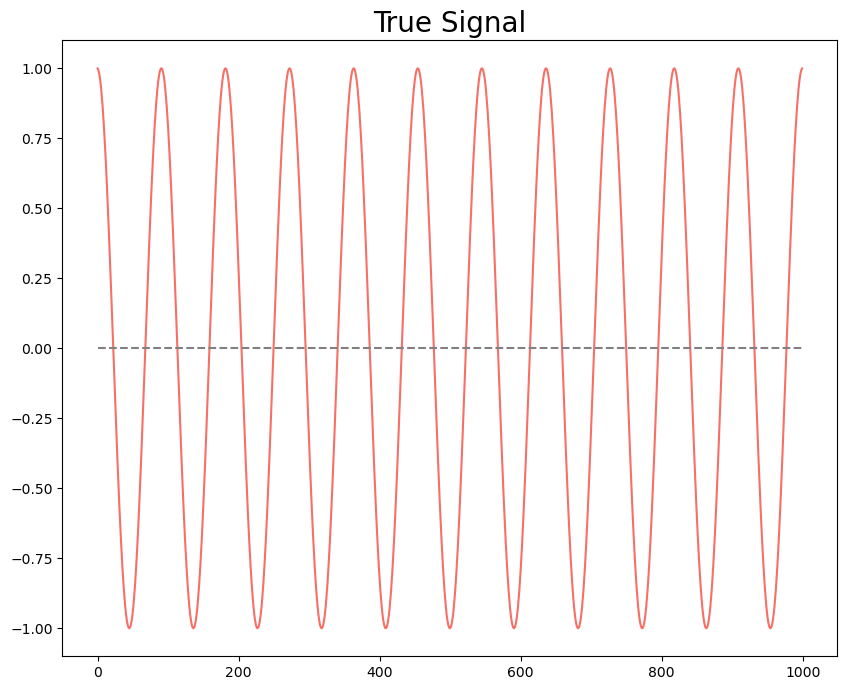

In [18]:
# Define a range of values
t = np.linspace(0, 22 * np.pi, 1000, endpoint=False)

# Set the noise level.
sigma = 3.0

# Define the signal.
x = np.cos(t + 11 * np.pi / 1000)

plot.line_plot(x, title='True Signal', ylim=(-1.1, 1.1))

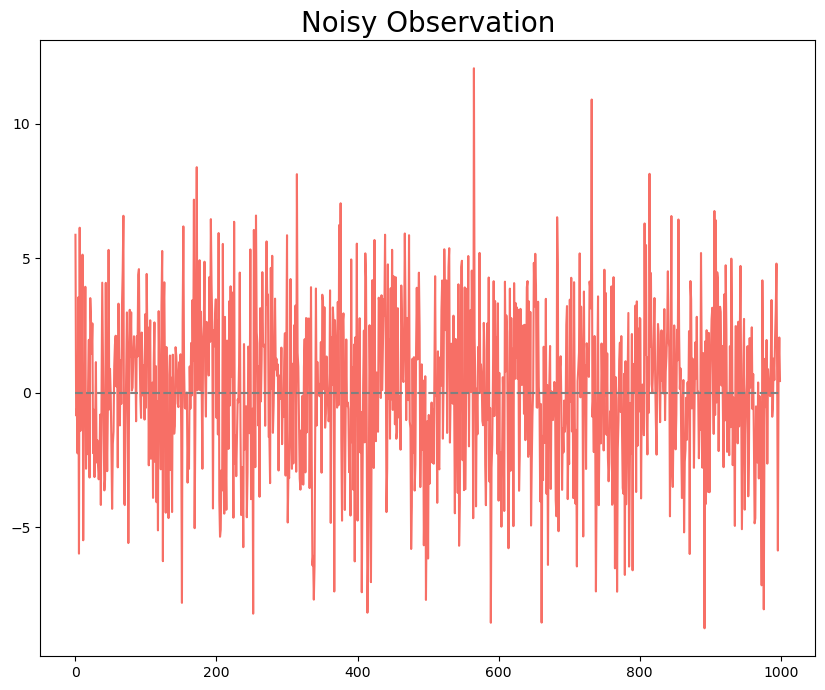

In [19]:
# Add noise to the signal.
np.random.seed(1)
y = x + sigma * np.random.randn(x.size)

plot.line_plot(y, title='Noisy Observation')

### <font color='#007acc'>Choose Sparse Representation</font>

Your first task is to identify an appropriate sparse domain for the signals.

### <font color='#e42d2f'>EXERCISE</font> 

In [17]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Define the sparse representations of the signals.
x_sparse = None
y_sparse = None

Now we can have a look at the siganls in the sparse domain you chose.

In [13]:
# Plot the signals
if x_sparse is not None:
    plot.line_plot(np.abs(x_sparse), title='True Signal in Sparse Domain')
if y_sparse is not None:
    plot.line_plot(np.abs(y_sparse), title='Noisy Observation in Sparse Domain')

Can you identify and similarities between the original and noisy signals in the sparse domain?

If not, you may want to rethink your choice.

### <font color='#007acc'>Denoising</font>

Your next task is to determine the appropriate threshold value, $\lambda$, and use this to remove the noise from the observed signal. 

### <font color='#e42d2f'>EXERCISE</font>

In [14]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Determine the value of lambda.
lambda_val = None

# Perform thresholding.
x_rec = None

Now let's look at the signal you have recovered.

In [15]:
# Plot the denoised signal
if x_rec is not None:
    plot.line_plot(np.real(x_rec), title='Denoised Signal', ylim=(-1.1, 1.1))

Did it work?

### <font color='#007acc'>Residual</font>

Finally, we can examine the residual of your recovered signal to get a sense of how close to the original signal it is.

$$x - \hat{x}$$

In [16]:
# Plot the residual
if x_rec is not None:
    plot.line_plot(np.real(x - x_rec), title='Residual', ylim=(-1.1, 1.1))

Which threshold produces the best residual? Why do we have a residual? Try decreasesing the noise added to the original signal and see what happens.

---

## <font color='#fdbf00'>Hints</font>

**Denoising Exercise Hints**

1. For your sparse representation you may want to use soemthing *fast and f(o)urious*.
1. Try not to get *mad* when choosing $\lambda$.
1. Thresholding signals can be quite *hard*.
1. Make sure you theshold in the correct domain.
1. Make sure your recovered signal is the correct domain.

[Open next notebook ->](./sparsity_2_compressed_sensing.ipynb)